# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [1]:
import sys
import json
from keras.models import Model, model_from_json
from volume_estimator import VolumeEstimator
from depth_estimation.custom_modules import *
from food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = '../models/segmentation/mask_rcnn_food_segmentation.h5'
classification_model_weights = '../models/classification/simple_model_weights.pth'
input_image = '../assets/readme_assets/examples/multi_image.jpg'

Using TensorFlow backend.
/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights ../models/segmentation/mask_rcnn_food_segmentation.h5


In [3]:
def load_model_and_weights():
    # Load the base model
    base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
    # Freeze the base model
    base_model.trainable = False
        
    # Add a global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        
    # Add a dense layer with 11 units and softmax activation for classification
    output = tf.keras.layers.Dense(11, activation='softmax')(x)
        
    # Create the model
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
        
    # Load the trained weights
    model.load_weights("../models/classification/inception_resnet_v2_classifier.h5")
        
    return model

estimator.loaded_model = load_model_and_weights()

[*] Creating intrinsics matrix from given FOV: 70
[*] Ellipse parameters: (167.63613891601562, 61.6871223449707, 45.5, 37.22727272727273, 1.5181439359526094)
[*] Found 2 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2883385237971309, 0.03335165595473637, -0.7841822072582219, -0.619633708625265]
[*] Estimated volume: 0.13921239336090355 L
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Predicted class: Noodles/Pasta
Total calories in predicted class: 0.1344791719866328


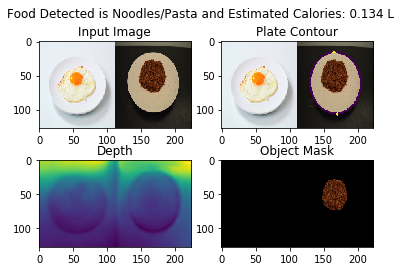

[*] Estimated plane parameters (w0,w1,w2,w3): [0.30080713159423145, 0.031214001242218365, -0.7971780704186283, -0.6029368210435345]
[*] Estimated volume: 0.13844048426588057 L
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Predicted class: Noodles/Pasta
Total calories in predicted class: 0.13373350780084062


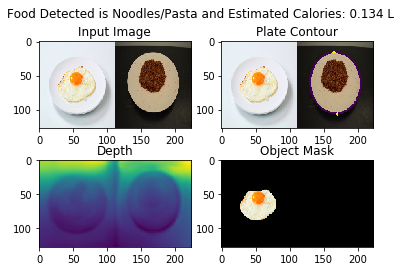

In [4]:
# Estimate volumes in input image
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

In [ ]:
%matplotlib notebook



# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()

<IPython.core.display.Javascript object>

/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.11818933791958577, -0.0057451890812953085…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.11381768956502883, 0.13497447495141826, 0.…

<IPython.core.display.Javascript object>

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.12163537228954381, 0.027598996256820198, 0…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.12011295176721283, 0.020775257629992185, …

<IPython.core.display.Javascript object>

In [14]:
# Create the Gradio interface
import gradio as gr
iface = gr.Interface(calories_function, 
                     inputs="image",
                     outputs="text",
                     title="Calories Estimator",
                     capture_session=True)  # Add capture_session=True to fix the error

iface.launch()


IMPORTANT: You are using gradio version 2.0.7, however version 3.14.0 is available, please upgrade.
--------
Running locally at: http://127.0.0.1:7864/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7864/', None)

[2024-03-19 21:39:32,574] ERROR in app: Exception on /api/predict/ [POST]
Traceback (most recent call last):
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask_cors/extension.py", line 176, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/amrit/anaconda3/envs/volume-esti

here
[*] Creating intrinsics matrix from given FOV: 70


: 